# Notebook for finding camera extrinsics of the IR + RGB stereo setup 

In [2]:
import numpy as np
import cv2
import csv
from pathlib import Path
import math
import datetime
import exifread

## Defining the respective camera intrinsics 

In [3]:
flir_intrinsics = np.array([[755.74748203,0.,317.3601524],
                    [0.0,755.32090533,262.23083607],
                    [0., 0., 1.]], dtype=np.float32)

zed_intrinsics = np.array([[514.80341605, 0., 644.92250454],
                    [0. , 514.95300697, 348.70670139],
                    [0.,0.,1.]], dtype=np.float32)


## Keypoint extraction from manually annotated images

In [4]:
# Paths for finding csv files containing keypoints 
flir_path = Path("/home/philip/uni/speciale/code_ws/Annotations/extrinsic/flir/")
zed_path = Path("/home/philip/uni/speciale/code_ws/Annotations/extrinsic/zed/")

flir_resolution = (640,512)
zed_resolution = (1280,720)


### Function for generating list of csv files 

In [5]:
def generate_list_of_csv(path_to_dir):
    """
    Returns a list of all the image paths in the provided directory
    """
    assert(path_to_dir.is_dir())
    file_paths_input = []
    for file in path_to_dir.iterdir():
        if file.suffix.lower() in ['.csv']:
            file_paths_input.append(file)
    return sorted(file_paths_input)

### Extract csv points from files 

In [6]:
flir_csv_list = generate_list_of_csv(flir_path)
zed_csv_list = generate_list_of_csv(zed_path)
temp_flir_kp = []
temp_zed_kp = []
for fname in flir_csv_list:
    frame_kp = []
    with open(fname,'r') as csv_file:
        csvreader = csv.reader(csv_file)

        for row in csvreader:
            frame_kp.append((int(row[1]),int(row[2])))
    temp_flir_kp.append(frame_kp)
flir_keypoints = np.array(temp_flir_kp,dtype=np.float32)
for fname in zed_csv_list:
    frame_kp = []
    with open(fname,'r') as csv_file:
        csvreader = csv.reader(csv_file)

        for row in csvreader:
            frame_kp.append((int(row[1]),int(row[2])))
    temp_zed_kp.append(frame_kp)
zed_keypoints = np.array(temp_zed_kp,dtype=np.float32)          

### Scaled keypoints as they are captured and calibrated at different resolutions

In [7]:
scale_factor_x = zed_intrinsics[0,0]/flir_intrinsics[0,0]
#scale_factor_y = zed_resolution[1]/flir_resolution[1]

flir_kp_scaled = flir_keypoints * scale_factor_x
#flir_kp_scaled[:, 0] *= scale_factor_x  # Scale x-coordinates
#flir_kp_scaled[:, 1] *= scale_factor_y  # Scale y-coordinates

# Scale the flir intrinsics 
# flir_intrinsics_scaled = flir_intrinsics.copy()
# flir_intrinsics_scaled[0, 0] *= scale_factor_x  # Adjust fx
# flir_intrinsics_scaled[1, 1] *= scale_factor_y  # Adjust fy
# flir_intrinsics_scaled[0, 2] *= scale_factor_x  # Adjust cx
# flir_intrinsics_scaled[1, 2] *= scale_factor_y  # Adjust cy



### Normalize coords

In [8]:
def normalize_keypoints(kp, K):
    """Normalize keypoints using the intrinsic matrix."""
    # Convert to homogeneous coordinates
    kp_h = np.hstack((kp, np.ones((kp.shape[0], 1))))
    # Normalize
    kp_norm = np.linalg.inv(K) @ kp_h.T
    return kp_norm[:2].T  # Return normalized coordinates (x, y)

## Obtain extrinsics 

In [9]:
fund_arr = []
num_images = flir_keypoints.shape[0]
ptsLeft = []
ptsRight = []
for i in range(num_images):

    flir_kp = flir_keypoints[i]
    zed_kp = zed_keypoints[i]

    F, mask = cv2.findFundamentalMat(flir_kp, zed_kp, cv2.FM_LMEDS)

    fund_arr.append(F)

for i in range(len(flir_keypoints[0])):
    ptsLeft.append(flir_keypoints[0][i])
    ptsRight.append(zed_keypoints[0][i])

ptsLeft = np.int32(ptsLeft)    
ptsRight = np.int32(ptsRight)    
ptstempl = ptsLeft
ptstempr = ptsRight
ptsLeft = ptsLeft[mask.ravel()==1]
ptsRight = ptsRight[mask.ravel()==1]

avg_F = np.mean(fund_arr,axis=0)

step_factor_x, step_factor_y = [],[]
offset_x, offset_y = [],[]

H, _ = cv2.findHomography(ptstempl,ptstempr, method=cv2.RANSAC)

print(H)


[[ 6.97681728e-01 -9.41330227e-02  4.22102466e+02]
 [ 7.27601110e-03  6.14641810e-01  2.01762029e+02]
 [ 1.79244345e-05 -1.43605926e-04  1.00000000e+00]]


# Illustrating the found extrinsics 

## Function for drawing epipolar lines and mouse call back function for picking point in image

### Load images for comparison purpose

In [10]:
import matplotlib.pyplot as plt
# Inputs (replace these with your actual variables)
flir_image = cv2.imread('/home/philip/uni/speciale/code_ws/Annotations/extrinsic/flir/0_annotated.jpg')
zed_image = cv2.imread('/home/philip/uni/speciale/code_ws/Annotations/extrinsic/zed/0_annotated.jpg')

print(zed_image.shape)
def drawlines(img1, img2, lines, pts1, pts2): 
	
	r, c, _ = img1.shape
	img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
	img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) 
	
	for r, pt1, pt2 in zip(lines, pts1, pts2): 
		
		color = tuple(np.random.randint(0, 255, 
										3).tolist()) 
		
		x0, y0 = map(int, [0, -r[2] / r[1] ]) 
		x1, y1 = map(int, 
					[c, -(r[2] + r[0] * c) / r[1] ]) 
		
		img1 = cv2.line(img1, 
						(x0, y0), (x1, y1), color, 1) 
		img1 = cv2.circle(img1, 
						tuple(pt1), 5, color, -1) 
		img2 = cv2.circle(img2, 
						tuple(pt2), 5, color, -1) 
	return img1, img2 



(720, 1280, 3)


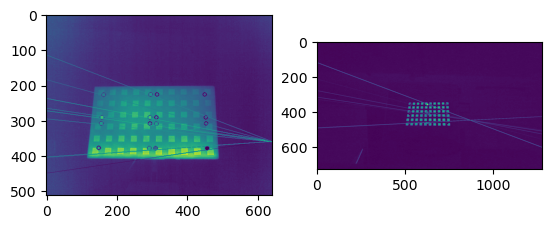

In [11]:
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1,
                                                          1,
                                                          2),
                                                          2, avg_F)
linesLeft = linesLeft.reshape(-1,3)

img5, img6 = drawlines(flir_image, zed_image,
                       linesLeft, ptsLeft,
                       ptsRight)

linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1,
                                                           1,
                                                           2),
                                                           1, avg_F)
linesRight = linesRight.reshape(-1,3)

img3, img4 = drawlines(zed_image,flir_image,
                       linesRight, ptsRight,
                       ptsLeft)
plt.subplot(121), plt.imshow(img5) 
plt.subplot(122), plt.imshow(img3) 
plt.show() 

In [12]:

def plot_camera_fov_with_fundamental_matrix(
    target_image, fundamental_matrix, source_width, source_height
):
    """
    Visualizes the FoV of a source camera on the target camera's image plane using the fundamental matrix.

    Parameters:
        target_image (np.ndarray): The target camera's image (to visualize the FoV).
        fundamental_matrix (np.ndarray): The 3x3 fundamental matrix mapping points from source to target camera.
        source_width (int): Width of the source camera's image.
        source_height (int): Height of the source camera's image.

    Returns:
        np.ndarray: Target image with the source camera's FoV drawn as a polygon.
    """
    # Define the corners of the source camera image
    source_corners = np.array([
        [0, 0],  # Top-left
        [source_width, 0],  # Top-right
        [source_width, source_height],  # Bottom-right
        [0, source_height]  # Bottom-left
    ], dtype=np.float32)

    # Convert corners to homogeneous coordinates
    source_corners_h = cv2.convertPointsToHomogeneous(source_corners).reshape(-1, 3)

    # Compute epipolar lines in the target camera's image
    epipolar_lines = cv2.computeCorrespondEpilines(source_corners_h, 1, fundamental_matrix).reshape(-1, 3)

    # Dimensions of the target camera's image
    height, width, _ = target_image.shape

    # Function to compute intersection of a line with image borders
    def compute_line_intersection(line, width, height):
        intersections = []
        a, b, c = line
        # Left border (x = 0)
        if b != 0:
            y = int(-c / b)
            if 0 <= y < height:
                intersections.append((0, y))
        # Right border (x = width)
        if b != 0:
            y = int(-(c + a * width) / b)
            if 0 <= y < height:
                intersections.append((width, y))
        # Top border (y = 0)
        if a != 0:
            x = int(-c / a)
            if 0 <= x < width:
                intersections.append((x, 0))
        # Bottom border (y = height)
        if a != 0:
            x = int(-(c + b * height) / a)
            if 0 <= x < width:
                intersections.append((x, height))
        return intersections

    # Find intersections of epipolar lines with the target image borders
    projected_points = []
    for line in epipolar_lines:
        intersections = compute_line_intersection(line, width, height)
        projected_points.extend(intersections)

    # Remove duplicates and create the convex hull
    if len(projected_points) > 0:
        projected_points = np.array(list(set(projected_points)), dtype=np.float32)
        hull = cv2.convexHull(projected_points)
        result_image = target_image.copy()
        cv2.polylines(result_image, [hull.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
        return result_image
    else:
        print("No valid intersections found. Check the fundamental matrix or input dimensions.")
        return target_image

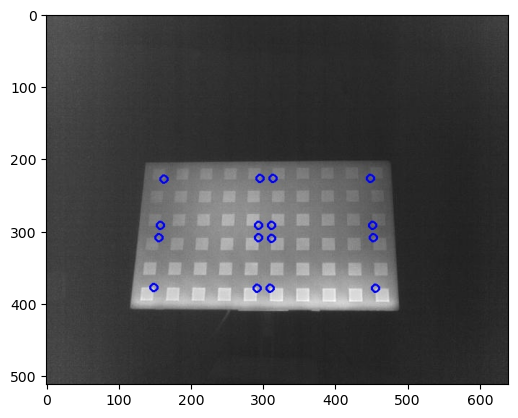

In [13]:
# result_image = plot_camera_fov_with_fundamental_matrix(
#     zed_image, avg_F, flir_resolution[0], flir_resolution[1]
# )
# Display the result
plt.imshow(cv2.cvtColor(flir_image, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()

### Find essential matrix, and decompose to obtain rotational relation 

In [14]:
def compute_essential_matrix(fundamental_matrix, intrinsics_camera1, intrinsics_camera2):
    """
    Computes the essential matrix from the fundamental matrix and camera intrinsics.

    Parameters:
        fundamental_matrix (np.ndarray): The 3x3 fundamental matrix.
        intrinsics_camera1 (np.ndarray): The 3x3 intrinsic matrix of the first camera.
        intrinsics_camera2 (np.ndarray): The 3x3 intrinsic matrix of the second camera.

    Returns:
        np.ndarray: The 3x3 essential matrix.
    """
    # Validate input shapes
    if fundamental_matrix.shape != (3, 3):
        raise ValueError("Fundamental matrix must be 3x3.")
    if intrinsics_camera1.shape != (3, 3) or intrinsics_camera2.shape != (3, 3):
        raise ValueError("Intrinsic matrices must be 3x3.")

    # Compute the essential matrix
    essential_matrix = intrinsics_camera2.T @ fundamental_matrix @ intrinsics_camera1

    # Enforce rank-2 constraint on the essential matrix
    # This is done by performing SVD and reconstructing the matrix
    U, S, Vt = np.linalg.svd(essential_matrix)
    S = np.diag([1, 1, 0])  # Set singular values to (1, 1, 0)
    essential_matrix = U @ S @ Vt

    return essential_matrix

In [15]:
essential_mat = compute_essential_matrix(avg_F, zed_intrinsics, flir_intrinsics)

#print(essential_mat)

R1,R2,t = cv2.decomposeEssentialMat(essential_mat)


In [16]:
# def check_correct_pose(R1, R2, t, K1, K2, pts1, pts2, batch_size=1000):
#     """
#     Determines the correct rotation and translation from the decomposed essential matrix.

#     Parameters:
#         R1 (np.ndarray): First possible rotation matrix (3x3).
#         R2 (np.ndarray): Second possible rotation matrix (3x3).
#         t (np.ndarray): Translation vector (3x1).
#         K1 (np.ndarray): Intrinsic matrix of the first camera.
#         K2 (np.ndarray): Intrinsic matrix of the second camera.
#         pts1 (np.ndarray): Matching points in the first image (Nx2).
#         pts2 (np.ndarray): Matching points in the second image (Nx2).
#         batch_size (int): Number of points to process in each batch to reduce memory usage.

#     Returns:
#         tuple: The correct rotation matrix and translation vector.
#     """
#     import numpy as np
#     import cv2

#     # Validate inputs
#     assert R1.shape == (3, 3), "R1 must be a 3x3 matrix"
#     assert R2.shape == (3, 3), "R2 must be a 3x3 matrix"
#     assert t.shape in [(3,), (3, 1)], "t must be a 3-element vector"
#     assert K1.shape == (3, 3), "K1 must be a 3x3 intrinsic matrix"
#     assert K2.shape == (3, 3), "K2 must be a 3x3 intrinsic matrix"
#     assert pts1.shape[1] == 2 and pts2.shape[1] == 2, "pts1 and pts2 must have shape Nx2"

#     # Ensure t is a column vector
#     t = t.reshape(-1, 1)

#     # Define the first camera projection matrix (reference)
#     P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # [I | 0]
#     P1 = K1 @ P1

#     # Possible solutions for the second camera
#     solutions = [
#         (R1, t),
#         (R1, -t),
#         (R2, t),
#         (R2, -t)
#     ]

#     max_positive_depth = -1
#     best_solution = None

#     for R, t_vec in solutions:
#         # Define the second camera projection matrix
#         P2 = np.hstack((R, t_vec))
#         P2 = K2 @ P2

#         num_positive_depth = 0

#         # Process points in batches
#         for i in range(0, len(pts1), batch_size):
#             pts1_batch = pts1[i:i+batch_size]
#             pts2_batch = pts2[i:i+batch_size]

#             # Triangulate points
#             points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_batch.T, pts2_batch.T)

#             # Handle division by zero and numerical instability
#             with np.errstate(divide='ignore', invalid='ignore'):
#                 valid_mask = points_4d_hom[3] != 0
#                 points_3d = np.zeros_like(points_4d_hom[:3])
#                 points_3d[:, valid_mask] = points_4d_hom[:3, valid_mask] / points_4d_hom[3, valid_mask]

#             # Check depth in both cameras
#             for j in range(points_3d.shape[1]):
#                 if valid_mask[j]:  # Skip invalid points
#                     point_cam2 = R @ points_3d[:, j] + t_vec.ravel()

#                     # Check if the point is in front of both cameras
#                     if points_3d[2, j] > 0 and point_cam2[2] > 0:
#                         num_positive_depth += 1

#         # Debug: Log the number of positive depth points for each solution
#         print(f"Solution (R, t_vec): num_positive_depth = {num_positive_depth}")

#         # Update the best solution
#         if num_positive_depth > max_positive_depth:
#             max_positive_depth = num_positive_depth
#             best_solution = (R, t_vec)

#     # Debug: Final selection
#     print(f"Best solution found with max_positive_depth = {max_positive_depth}")
#     return best_solution


In [17]:
# best_solution = check_correct_pose(R1,R2,t,zed_intrinsics,flir_intrinsics,ptsRight,ptsLeft)


# #print(best_solution[0])
# t_C_to_IR = np.array([t[0][0],t[1][0],t[2][0]])#np.array([-10,0,7.5])
# R_best = np.array(best_solution[0])
# #print(R_best)
# print(t_C_to_IR)
# T_C_to_IR = np.eye(4)
# T_C_to_IR[:3,:3] = R_best
# T_C_to_IR[:3, 3] = t_C_to_IR 

# print(T_C_to_IR.shape)

In [18]:
def draw_rectangle(image, points, color=(0, 255, 0), thickness=2):
    """
    Draws a rectangle on the image using the provided corner points.

    Parameters:
        image (numpy.ndarray): The input image where the rectangle will be drawn.
        points (list of tuples): List of 4 pixel coordinates (x, y) as corner points.
                                The points should be in the following order:
                                top-left, top-right, bottom-right, bottom-left.
        color (tuple): Color of the rectangle (B, G, R).
        thickness (int): Thickness of the rectangle edges.

    Returns:
        numpy.ndarray: The image with the rectangle drawn.
    """
    if len(points) != 4:
        raise ValueError("Exactly 4 points are required to draw a rectangle.")

    # Convert points to an integer numpy array
    points = np.array(points, dtype=np.int32)

    # Draw lines connecting the points to form a rectangle
    for i in range(4):
        start_point = tuple(points[i])
        end_point = tuple(points[(i + 1) % 4])  # Wrap around to the first point
        cv2.line(image, start_point, end_point, color, thickness)

    return image


[array([422.10246603, 201.76202859]), array([858.0927417 , 204.07399458]), array([873.94135534, 554.85492837]), array([403.6191236 , 556.69579432])]


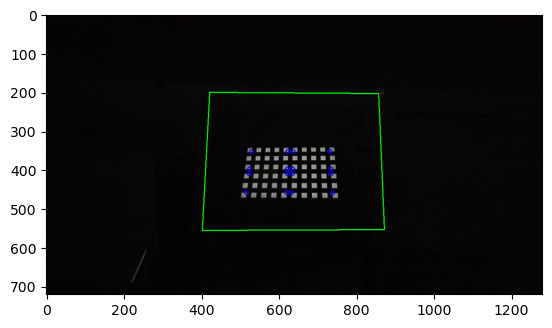

In [ ]:
flir_cnrs = np.array([[0,0,1],
                      [flir_resolution[0]-1,0,1]
                      ,[flir_resolution[0]-1,flir_resolution[1]-1,1],
                      [0,flir_resolution[1]-1,1]])

zed_flir_cnrs = []

for pts in flir_cnrs:
    temp = np.dot(H,pts)
    zed_flir_cnrs.append(temp[:2]/temp[2])

print(zed_flir_cnrs)    

resultimage = draw_rectangle(zed_image,zed_flir_cnrs)
# Display the result
plt.imshow(cv2.cvtColor(resultimage, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()


556


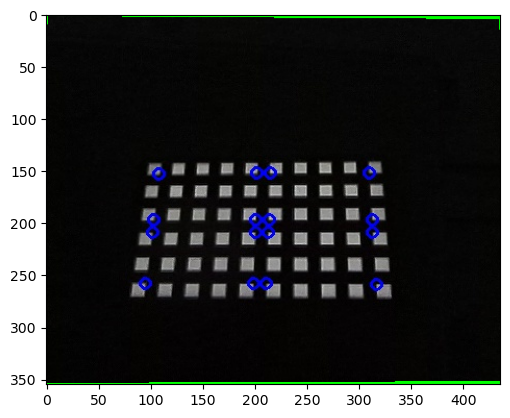

In [30]:
zed_flir_cnrs = np.array(zed_flir_cnrs)
print(int(zed_flir_cnrs[3,1]))

cropped_img = resultimage[int(zed_flir_cnrs[0,1]):int(zed_flir_cnrs[3,1]),int(zed_flir_cnrs[0,0]):int(zed_flir_cnrs[1,0])]

# Display the result
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.axis()
plt.show()